### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

### 1.2 Creando el Notebook

In [1]:
import ads

In [2]:
ads.__version__

'2.5.4'

### 1.3 Lectura de la base de datos

In [3]:
from ads.dataset.factory import DatasetFactory

In [4]:
ds = DatasetFactory.open('datos_salud_final.csv')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
ds

HTML(value='\n        <style>\n            .mostly-customized-scrollbar {\n              display: block;\n    …

6,954 rows, 16 columns

In [6]:
type(ds)

ads.dataset.dataset.ADSDataset

In [7]:
ds.columns

Index(['sexo', 'edad', 'fumador', 'cigarrillos_por_dia',
       'uso_medicamento_presion', 'acv', 'hipertension', 'diabetes',
       'colesterol_total', 'presion_arterial_sistolica',
       'presion_arterial_diastolica', 'imc', 'frecuencia_cardiaca', 'glicemia',
       'categoria_de_fumador', 'riesgo_eac_decada'],
      dtype='object')

In [8]:
ds = DatasetFactory.open('datos_salud_final.csv', target='riesgo_eac_decada')
ds.head()

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

,sexo,edad,fumador,cigarrillos_por_dia,uso_medicamento_presion,acv,hipertension,diabetes,colesterol_total,presion_arterial_sistolica,presion_arterial_diastolica,imc,frecuencia_cardiaca,glicemia,categoria_de_fumador,riesgo_eac_decada
0,1,39,0,0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,0
1,0,46,0,0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,0
2,1,48,1,20,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,2,0
3,0,61,1,30,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,3,1
4,0,46,1,23,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,3,0


In [9]:
type(ds)

ads.dataset.classification_dataset.BinaryClassificationDataset

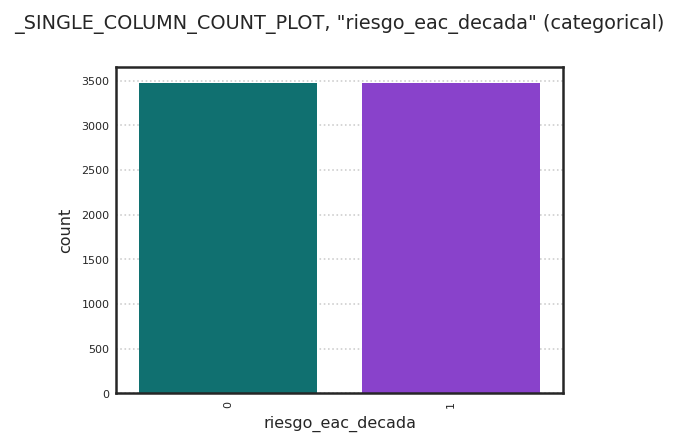

In [10]:
ds.target.show_in_notebook()

### 1.4 Creando nuestro primer modelo

In [11]:
import numpy as np

np.random.seed(42)

In [12]:
train, test = ds.train_test_split()

In [13]:
train.X

,sexo,edad,fumador,cigarrillos_por_dia,uso_medicamento_presion,acv,hipertension,diabetes,colesterol_total,presion_arterial_sistolica,presion_arterial_diastolica,imc,frecuencia_cardiaca,glicemia,categoria_de_fumador
4782,1,49,1,20,0,0,1,0,193.0,172.0,105.0,19.70,90.0,77.0,2
208,0,43,0,0,0,0,0,0,263.0,115.0,82.5,25.91,105.0,81.8,0
1373,1,42,1,20,0,0,0,0,231.0,123.0,87.0,21.48,75.0,44.0,2
6816,1,52,1,25,0,0,1,0,206.0,173.0,117.0,29.63,75.0,77.0,3
3357,1,45,1,20,0,0,0,0,200.0,113.0,75.5,21.51,88.0,72.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1,43,1,20,0,0,0,0,184.0,127.5,81.0,28.31,108.0,75.0,2
5191,1,52,1,20,0,0,0,0,225.0,126.0,75.0,22.18,85.0,100.0,2
5226,0,60,0,0,0,0,1,0,334.0,132.0,94.0,25.38,80.0,98.0,0
5390,1,54,1,43,0,0,0,0,243.0,135.0,92.0,31.30,90.0,65.0,3


In [14]:
test.X

,sexo,edad,fumador,cigarrillos_por_dia,uso_medicamento_presion,acv,hipertension,diabetes,colesterol_total,presion_arterial_sistolica,presion_arterial_diastolica,imc,frecuencia_cardiaca,glicemia,categoria_de_fumador
5487,1,61,1,15,0,0,0,0,204.0,120.0,80.0,25.71,80.0,83.0,2
5489,0,50,0,0,0,0,1,0,236.0,152.0,92.0,24.47,120.0,67.0,0
2133,1,42,1,20,0,0,0,0,182.0,120.0,83.0,27.26,85.0,87.0,2
37,1,52,0,0,0,0,1,1,178.0,160.0,98.0,40.11,75.0,225.0,0
2063,1,42,0,0,0,0,0,0,258.0,110.0,69.0,26.25,60.0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5861,1,62,0,0,0,0,1,0,208.0,144.0,80.0,31.42,75.0,66.0,0
5465,1,67,1,15,0,1,1,0,285.0,155.0,90.0,30.42,70.0,77.0,2
2509,0,57,0,0,0,0,1,0,382.0,133.0,77.0,24.27,75.0,81.0,0
6261,1,56,1,20,0,0,1,0,205.0,210.0,130.0,25.49,95.0,127.0,2


In [15]:
train.y

4782    1
208     0
1373    0
6816    1
3357    0
       ..
3772    0
5191    1
5226    1
5390    1
860     0
Name: riesgo_eac_decada, Length: 6258, dtype: int64

In [16]:
test.y

5487    1
5489    1
2133    0
37      0
2063    0
       ..
5861    1
5465    1
2509    0
6261    1
4240    1
Name: riesgo_eac_decada, Length: 696, dtype: int64

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
primer_modelo = DecisionTreeClassifier()

In [19]:
primer_modelo.fit(train.X, train.y)

DecisionTreeClassifier()

In [20]:
primer_modelo.score(test.X, test.y)

0.9037356321839081

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

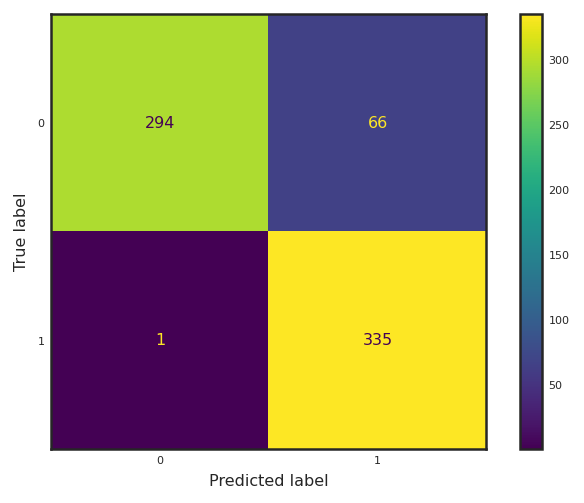

In [22]:
matriz = ConfusionMatrixDisplay.from_estimator(estimator=primer_modelo, X= test.X, y= test.y)

### 1.5 Mejorando el primer modelo

In [23]:
modelo_profundo = DecisionTreeClassifier(max_depth=100)

In [24]:
modelo_profundo.fit(train.X, train.y)

DecisionTreeClassifier(max_depth=100)

In [25]:
modelo_profundo.score(test.X,test.y)

0.9037356321839081

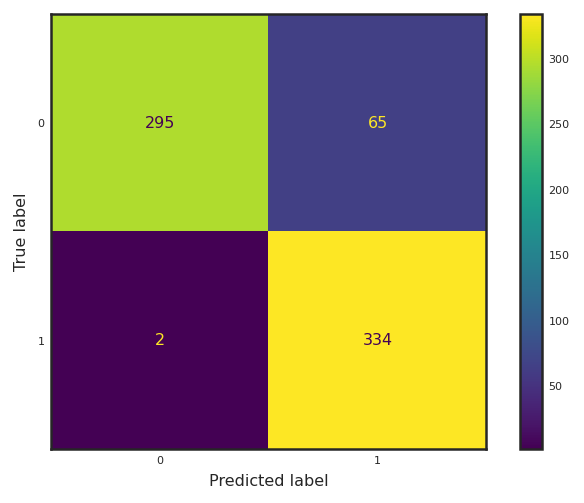

In [26]:
matriz = ConfusionMatrixDisplay.from_estimator(estimator=modelo_profundo, X= test.X, y= test.y)

### 1.6 Selección de Features

In [27]:
atributos = primer_modelo.feature_importances_
atributos

array([0.01853897, 0.17957426, 0.00295501, 0.05574134, 0.00436476,
       0.00360557, 0.01087495, 0.00112619, 0.13213862, 0.13855885,
       0.10833617, 0.14218719, 0.08551006, 0.11211416, 0.0043739 ])

In [28]:
import pandas as pd

pd.Series(atributos, index= train.X.columns).sort_values()

diabetes                       0.001126
fumador                        0.002955
acv                            0.003606
uso_medicamento_presion        0.004365
categoria_de_fumador           0.004374
hipertension                   0.010875
sexo                           0.018539
cigarrillos_por_dia            0.055741
frecuencia_cardiaca            0.085510
presion_arterial_diastolica    0.108336
glicemia                       0.112114
colesterol_total               0.132139
presion_arterial_sistolica     0.138559
imc                            0.142187
edad                           0.179574
dtype: float64

In [29]:
train.X.drop(columns='diabetes', axis=1, inplace=True)

In [30]:
test.X.drop(columns='diabetes', axis=1, inplace=True)

In [31]:
train.X.columns

Index(['sexo', 'edad', 'fumador', 'cigarrillos_por_dia',
       'uso_medicamento_presion', 'acv', 'hipertension', 'colesterol_total',
       'presion_arterial_sistolica', 'presion_arterial_diastolica', 'imc',
       'frecuencia_cardiaca', 'glicemia', 'categoria_de_fumador'],
      dtype='object')

In [32]:
test.X.columns

Index(['sexo', 'edad', 'fumador', 'cigarrillos_por_dia',
       'uso_medicamento_presion', 'acv', 'hipertension', 'colesterol_total',
       'presion_arterial_sistolica', 'presion_arterial_diastolica', 'imc',
       'frecuencia_cardiaca', 'glicemia', 'categoria_de_fumador'],
      dtype='object')

In [33]:
primer_modelo.fit(train.X, train.y)

DecisionTreeClassifier()

In [34]:
primer_modelo.score(test.X, test.y)

0.9066091954022989

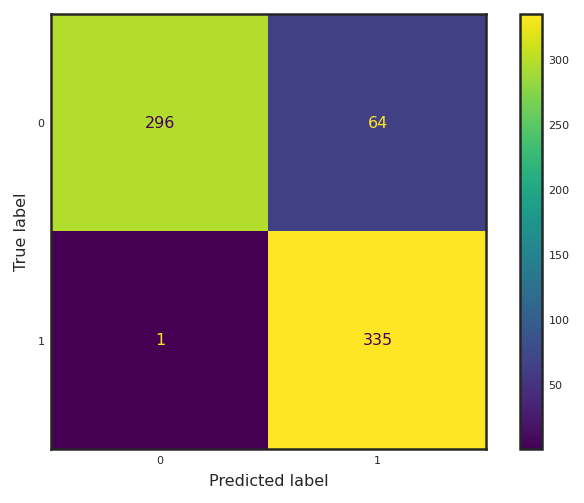

In [35]:
matriz = ConfusionMatrixDisplay.from_estimator(estimator=primer_modelo, X= test.X, y= test.y)